# Задание на итоговую аттестацию по курсу "Инженер данных" (1T Sprint).

**Проект № 5.** Служба такси.

Все операции должны считаться локально.

Есть таблица, состоящая из поездок такси в Нью-Йорке.

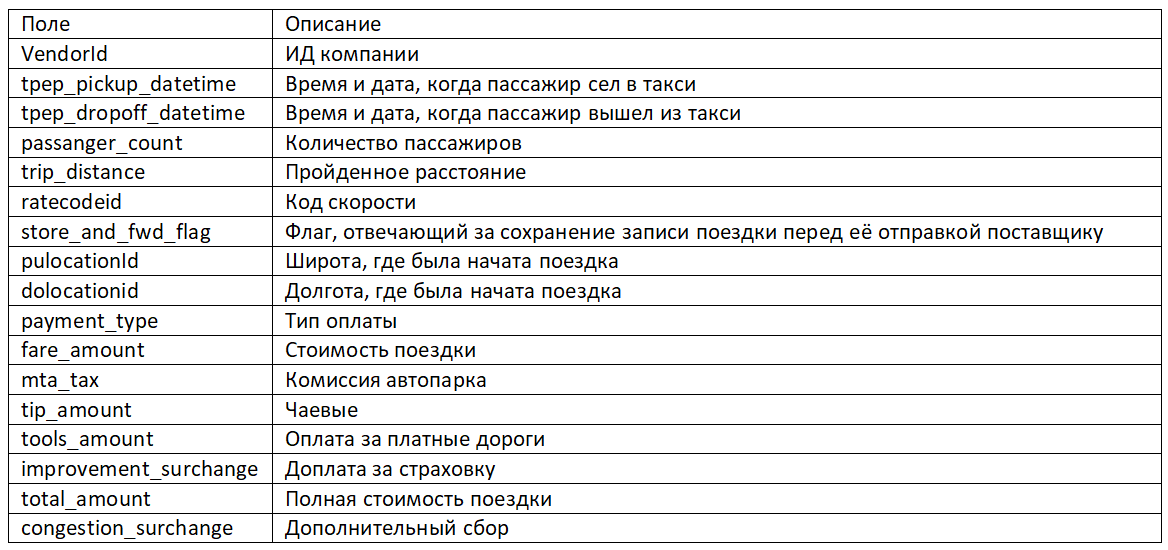

 

Источник: https://disk.yandex.ru/d/DKeoopbGH1Ttuw

**Необходимо**, используя таблицу поездок для каждого дня рассчитать процент поездок по количеству человек в машине (без пассажиров, 1, 2, 3, 4 и более пассажиров). По итогу должна получиться таблица (parquet) с колонками date, percentage_zero, percentage_1p, percentage_2p, percentage_3p, percentage_4p_plus. Технологический стек – sql, scala (что-то одно).
Также добавить столбцы к предыдущим результатам с самой дорогой и самой дешевой поездкой для каждой группы.

**Дополнительно**: также провести аналитику и построить график на тему “как пройденное расстояние и количество пассажиров влияет на чаевые” в любом удобном инструменте.

In [1]:
# установка Spark в Colab

!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# импорт необходимых библиотек

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

import pyspark.sql.types as T
import pyspark.sql.functions as F

from datetime import datetime

In [3]:
conf = SparkConf()
conf.setMaster('local').setAppName('final_task')

sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)


print('Spark: ', spark.version)

Spark:  3.3.1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# загружаем данные

df = spark.read.format("csv").option("header", "true").load("/content/drive/My Drive/yellow_tripdata_2020-01.csv")
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2020-01-01 00:28:15|  2020-01-01 00:33:03|              1|         1.20|         1|                 N|         238|         239|           1|          6|    3|    0.5|      1.47|           0|                  0.3

In [6]:
# группируем данные по дню, выделяем 5 групп пассажиров (в зависимости от количества), 
# находим количество пассажиров, сумму самой дорогой и сумму самой дешевой поездки по группам в день 

leftDF = df.groupBy(F.date_trunc("Day", df["tpep_pickup_datetime"]).alias("date"), F.when(df["passenger_count"].cast("int") == 0, "percentage_zero").when(df["passenger_count"].cast("int") == 1, "percentage_1p").when(df["passenger_count"].cast("int") == 2, "percentage_2p").when(df["passenger_count"].cast("int") == 3, "percentage_3p").otherwise("percentage_4p_plus").alias("new_passenger_group")).agg(F.count(df["passenger_count"]).alias("count_day_group"), F.max(df["fare_amount"].cast("float")).alias("max_count_day"), F.min(df["fare_amount"].cast("float")).alias("min_count_day"))
leftDF.show()

+-------------------+-------------------+---------------+-------------+-------------+
|               date|new_passenger_group|count_day_group|max_count_day|min_count_day|
+-------------------+-------------------+---------------+-------------+-------------+
|2020-01-07 00:00:00|      percentage_1p|         145755|        383.0|       -133.5|
|2008-12-31 00:00:00|      percentage_3p|              1|          4.5|          4.5|
|2020-01-01 00:00:00| percentage_4p_plus|          16421|        326.0|        -76.5|
|2020-01-05 00:00:00| percentage_4p_plus|          13831|        220.0|        -65.0|
|2020-01-01 00:00:00|      percentage_3p|           9680|        400.0|       -100.0|
|2020-01-02 00:00:00|      percentage_3p|           7592|        162.0|        -65.0|
|2020-01-06 00:00:00|      percentage_2p|          23738|        230.0|        -65.0|
|2020-01-09 00:00:00|      percentage_2p|          30794|        220.5|        -94.5|
|2020-01-08 00:00:00|    percentage_zero|           38

In [7]:
# группируем данные по дням, находим общее количество поездок в день
rightDF = df.groupBy(F.date_trunc("Day", df["tpep_pickup_datetime"]).alias("date")).count()
rightDF.show()

+-------------------+------+
|               date| count|
+-------------------+------+
|2003-01-01 00:00:00|     1|
|2020-01-05 00:00:00|164399|
|2020-01-04 00:00:00|182752|
|2020-01-06 00:00:00|179515|
|2020-01-08 00:00:00|217100|
|2009-01-01 00:00:00|    19|
|2020-01-03 00:00:00|183477|
|2020-01-09 00:00:00|231684|
|2020-01-01 00:00:00|169437|
|2021-01-02 00:00:00|     3|
|2019-12-31 00:00:00|   129|
|2020-01-07 00:00:00|201520|
|2008-12-31 00:00:00|    10|
|2019-12-18 00:00:00|     2|
|2020-01-02 00:00:00|162141|
|2020-01-30 00:00:00|242994|
|2020-02-23 00:00:00|     1|
|2020-01-15 00:00:00|217496|
|2020-01-13 00:00:00|209210|
|2020-01-10 00:00:00|228201|
+-------------------+------+
only showing top 20 rows



In [8]:
# объединяем полученные фреймы по дате, находим процент поездок по количеству человек в машине для каждого дня

fullDF = leftDF.join(rightDF, leftDF["date"] == rightDF["date"], "left").select(rightDF["date"], leftDF["new_passenger_group"], (F.lit(100)*leftDF["count_day_group"]/rightDF["count"]).alias("cnt"), leftDF["min_count_day"], leftDF["max_count_day"]).sort("date")
fullDF.show()

+-------------------+-------------------+------------------+-------------+-------------+
|               date|new_passenger_group|               cnt|min_count_day|max_count_day|
+-------------------+-------------------+------------------+-------------+-------------+
|2003-01-01 00:00:00|      percentage_1p|             100.0|          0.0|          0.0|
|2008-12-31 00:00:00|      percentage_1p|              80.0|          3.5|         52.0|
|2008-12-31 00:00:00|      percentage_3p|              10.0|          4.5|          4.5|
|2008-12-31 00:00:00| percentage_4p_plus|              10.0|         52.0|         52.0|
|2009-01-01 00:00:00| percentage_4p_plus|10.526315789473685|          8.5|         52.0|
|2009-01-01 00:00:00|      percentage_1p| 78.94736842105263|          2.5|         74.5|
|2009-01-01 00:00:00|      percentage_3p|5.2631578947368425|         10.5|         10.5|
|2009-01-01 00:00:00|      percentage_2p|5.2631578947368425|         30.0|         30.0|
|2019-12-18 00:00:00|

In [9]:
# транспонируем данные к нужному формату 
# (преобразуем строки с группами пассажиров в столбцы, добавляем столбцы с суммами самой дорогой и самой дешевой поездкой для каждой группы)

pivotDF = fullDF.groupBy("date").pivot("new_passenger_group").agg(F.max("cnt").alias("cnt"), F.min("min_count_day").alias("min_count_day"), F.max("max_count_day").alias("max_count_day")).sort("date")
pivotDF.show()

+-------------------+-----------------+---------------------------+---------------------------+------------------+---------------------------+---------------------------+------------------+---------------------------+---------------------------+----------------------+--------------------------------+--------------------------------+-------------------+-----------------------------+-----------------------------+
|               date|percentage_1p_cnt|percentage_1p_min_count_day|percentage_1p_max_count_day| percentage_2p_cnt|percentage_2p_min_count_day|percentage_2p_max_count_day| percentage_3p_cnt|percentage_3p_min_count_day|percentage_3p_max_count_day|percentage_4p_plus_cnt|percentage_4p_plus_min_count_day|percentage_4p_plus_max_count_day|percentage_zero_cnt|percentage_zero_min_count_day|percentage_zero_max_count_day|
+-------------------+-----------------+---------------------------+---------------------------+------------------+---------------------------+---------------------------+

In [11]:
pivotDF.write.parquet("/content/drive/My Drive/tripdata_output_1.parquet")